<a href="https://colab.research.google.com/github/FaisalT0435/Artefak-TA/blob/main/KFold_MASK_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pycocotools
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import os

In [ ]:
os.chdir('/content/drive/MyDrive/Mask_RCNN/Dataset')

In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1Qkzrv5ICHEwHA89LN6xQS4alzi6bZysW/Mask_RCNN/Dataset


In [ ]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 4
NUM_EPOCHS = 1
NUM_WORKERS = 4
CHECKPOINT_FILE = "1152KaggleBest.pth.tar"
PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = True
TRAIN_DIR = 'train'
VALID_DIR = 'valid'
TEST_DIR = 'test'
IMAGE_SIZE = [416,416]

In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [ ]:
import numpy as np

In [ ]:
class CCDataset(Dataset):
  def __init__(self, mode = 'train', augmentation=None):
    if mode == 'train':
      self.dataset_path = TRAIN_DIR
      ann_path = os.path.join(TRAIN_DIR, '_annotations.coco.json')
    if mode == 'valid':
      self.dataset_path = VALID_DIR
      ann_path = os.path.join(VALID_DIR, '_annotations.coco.json')
    if mode == 'test':
      self.dataset_path = TEST_DIR
      ann_path = os.path.join(TEST_DIR, '_annotations.coco.json')
    
    self.coco = COCO(ann_path)
    self.cat_ids = self.coco.getCatIds()
    self.augmentation=augmentation

  def __len__(self):
      return len(self.coco.imgs)
  
  def get_masks(self, index):
      ann_ids = self.coco.getAnnIds([index])
      anns = self.coco.loadAnns(ann_ids)
      masks=[]

      for ann in anns:
            mask = self.coco.annToMask(ann)
            masks.append(mask)

      return masks

  def get_boxes(self, masks):
      num_objs = len(masks)
      boxes = []

      for i in range(num_objs):
          x,y,w,h = cv2.boundingRect(masks[i])
          boxes.append([x, y, x+w, y+h])

      return np.array(boxes)

  def __getitem__(self, index):
      # Load image
      img_info = self.coco.loadImgs([index])[0]
      image = cv2.imread(os.path.join(self.dataset_path,
                                    img_info['file_name']))
      masks = self.get_masks(index)

      if self.augmentation:
        augmented = self.augmentation(image=image, masks=masks)
        image, masks = augmented['image'], augmented['masks']

      image = image.transpose(2,0,1) / 255.

      # Load masks
      masks = np.array(masks)
      boxes = self.get_boxes(masks)

      # Create target dict
      num_objs = len(masks)
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.ones((num_objs,), dtype=torch.int64)
      masks = torch.as_tensor(masks, dtype=torch.uint8)
      image = torch.as_tensor(image, dtype=torch.float32)
      data = {}
      data["boxes"] =  boxes
      data["labels"] = labels
      data["masks"] = masks

      return image, data

In [ ]:
def collate_fn(batch):
  images = list()
  targets = list()
  for b in batch:
        images.append(b[0])
        targets.append(b[1])
  images = torch.stack(images, dim=0)
  return images, targets

In [ ]:
import albumentations as A
import numpy as np # linear algebra


In [ ]:
import pandas as pd

In [ ]:
transform = A.Compose([
    A.Resize(600,600),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(
        contrast_limit=0.2, brightness_limit=0.3, p=0.5),
    A.OneOf([
        A.ImageCompression(p=0.8),
        A.RandomGamma(p=0.8),
        A.Blur(p=0.8),
        A.Equalize(mode='cv',p=0.8)
    ], p=1.0),
    A.OneOf([
        A.ImageCompression(p=0.8),
        A.RandomGamma(p=0.8),
        A.Blur(p=0.8),
        A.Equalize(mode='cv',p=0.8),
    ], p=1.0)
])

In [ ]:
import torch
from tqdm import tqdm
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import datasets, models

In [ ]:
# n_classes = 3
coco = COCO(os.path.join( "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


{0: {'id': 0, 'name': 'Pest', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Belalang', 'supercategory': 'Pest'},
 2: {'id': 2, 'name': 'Sehat', 'supercategory': 'Pest'},
 3: {'id': 3, 'name': 'Ulat', 'supercategory': 'Pest'},
 4: {'id': 4, 'name': 'Wereng', 'supercategory': 'Pest'}}

In [ ]:
def get_model():
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
            in_features, num_classes=n_classes)
    model.to(DEVICE)
    
    return model

In [ ]:
def save_checkpoint(state, filename="mask_rcnn.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    #optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
if LOAD_MODEL and CHECKPOINT_FILE in os.listdir():
        print("Loading checkpoint")
        load_checkpoint(torch.load(CHECKPOINT_FILE), model, optimizer, LEARNING_RATE)

In [ ]:
y = os.path.join( 'train')
y

'train'

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset


In [ ]:
def train_one_epoch(loader, model, optimizer, device):
    loop = tqdm(loader)

    all_losses = []
    all_losses_dict = []
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    for batch_idx, (images, targets) in  enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
          
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
          
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)


        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    
    return(np.mean(all_losses))
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Mask_RCNN/Dataset/test/_classes.csv', sep=',')



In [ ]:
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

In [ ]:
test_labels = labels.apply(get_label, axis=1)

In [ ]:
best_vloss = np.inf
def validate(loader, model, optimizer, device, epoch):
    global best_vloss
    loop = tqdm(loader)
    running_vloss = 0
    for batch_idx, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
          loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        running_vloss += losses
        
    avg_vloss = running_vloss / (batch_idx + 1)
    
    print(f"Avg Valid Loss: {avg_vloss}")
    if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      if SAVE_MODEL:
            print("Model improved, saving...")
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=f"1152KaggleBest_second_{epoch}.pth.tar")
    print('\n')
    return avg_vloss

In [ ]:
def predict_single_frame(frame):
    images = cv2.resize(frame, IMAGE_SIZE, cv2.INTER_LINEAR)/255
    images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
    images = images.swapaxes(1, 3).swapaxes(2, 3)
    images = list(image.to(DEVICE) for image in images)
    
    with torch.no_grad():
      pred = model(images)
    
    # print(pred)
    
    im = images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.float32)
    im2 = np.zeros_like(im).astype(np.float32)
    for i in range(len(pred[0]['masks'])):
        msk=pred[0]['masks'][i,0].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        box=pred[0]['boxes'][i].detach().cpu().numpy()
        lbl=pred[0]['labels'][i].detach().cpu().numpy()
        
        if (lbl == 1):
          x = " Belalang"
        elif  (lbl == 2):
          x = " Sehat"
        elif  (lbl == 3):
          x = " Ulat"
        elif  (lbl == 4):
          x = " Wereng"
        # print(x)
        if scr>0.4 :
            cv2.rectangle(im, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,1), 2)
            cv2.putText(im, "{0:.2f}%".format(scr*100), (int(box[0]+10), int(box[1])+40), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,0,1), 2, cv2.LINE_AA)
            cv2.putText(im, x , (int(box[0]+4), int(box[1])+15), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,0,1), 2, cv2.LINE_AA)
            im2[:,:,0][msk>0.87] = np.random.uniform(0,1)
            im2[:, :, 1][msk > 0.87] = np.random.uniform(0,1)
            im2[:, :, 2][msk > 0.87] = np.random.uniform(0,1)
            

    return (cv2.addWeighted(im, 0.8, im2, 0.2,0)*255).astype(np.uint8), x

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
FOLD 0
--------------------------------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can

  0%|          | 0.00/170M [00:00<?, ?B/s]

Epoch: 0


100%|██████████| 15/15 [00:41<00:00,  2.77s/it]


Avg Valid Loss: 1.6953519582748413


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 1.4037196636199951


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 1.301886796951294


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 1.230594515800476


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 1.2134209871292114


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Avg Valid Loss: 1.1555688381195068


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 1.1416834592819214


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 1.124921202659607


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 1.1136127710342407


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 1.1054471731185913


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 1.0681594610214233


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 1.0574345588684082


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 1.0465517044067383


Epoch: 13


100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Avg Valid Loss: 1.0279545783996582


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 1.0055853128433228


Epoch: 15


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Avg Valid Loss: 1.00735604763031


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.9973451495170593


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Avg Valid Loss: 0.9913046360015869


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 0.9570381045341492


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 0.9994947910308838


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.9793962240219116


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 0.9411829113960266


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 0.9611244797706604


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 0.9333611130714417


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Avg Valid Loss: 0.9589412212371826




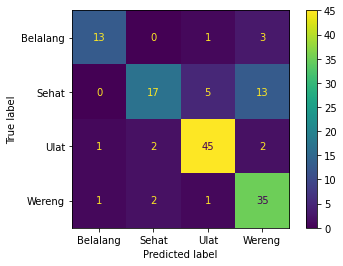

              precision    recall  f1-score   support

    Belalang       0.87      0.76      0.81        17
       Sehat       0.81      0.49      0.61        35
        Ulat       0.87      0.90      0.88        50
      Wereng       0.66      0.90      0.76        39

    accuracy                           0.78       141
   macro avg       0.80      0.76      0.77       141
weighted avg       0.79      0.78      0.77       141

[1.0266690910259881]
[1.0967375063896179]
FOLD 1
--------------------------------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can

Epoch: 0


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Avg Valid Loss: 1.5835779905319214


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 1.2958358526229858


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Avg Valid Loss: 1.1375669240951538


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 1.0916693210601807


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 1.0867588520050049


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 1.0266165733337402


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 1.0177137851715088


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.9904816746711731


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 0.9774304628372192


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.9288787245750427


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 0.9369233846664429


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 0.9264177680015564


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 0.9143601059913635


Epoch: 13


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 0.9013606309890747


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 0.9010491967201233


Epoch: 15


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 0.8876943588256836


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.9002112150192261


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 0.885646402835846


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.874039351940155


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 0.8741984963417053


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 0.8684722781181335


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 0.8384281992912292


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 0.8223152756690979


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.804071843624115


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

Avg Valid Loss: 0.820453941822052




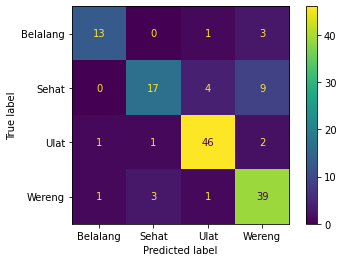

              precision    recall  f1-score   support

    Belalang       0.87      0.76      0.81        17
       Sehat       0.81      0.57      0.67        30
        Ulat       0.88      0.92      0.90        50
      Wereng       0.74      0.89      0.80        44

    accuracy                           0.82       141
   macro avg       0.82      0.78      0.80       141
weighted avg       0.82      0.82      0.81       141

[1.0266690910259881, 1.0586435804367065]
[1.0967375063896179, 0.9716869044303894]
FOLD 2
--------------------------------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can

Epoch: 0


100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Avg Valid Loss: 1.6654826402664185


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 1.3301478624343872


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Avg Valid Loss: 1.232445240020752


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 1.2094968557357788


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 1.156683325767517


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 1.1111884117126465


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 1.076185703277588


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 1.064677357673645


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 1.0327707529067993


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Avg Valid Loss: 0.9946599006652832


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 1.0031577348709106


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 0.9855844378471375


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.9451692700386047


Epoch: 13


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 0.9500147104263306


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 0.9494078755378723


Epoch: 15


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Avg Valid Loss: 0.8954936265945435


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Avg Valid Loss: 0.9021762013435364


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 0.9170784950256348


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 0.9095970392227173


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Avg Valid Loss: 0.906721293926239


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 0.8618392944335938


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.90317302942276


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 0.8768109679222107


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 0.8924859166145325


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]

Avg Valid Loss: 0.8563922643661499




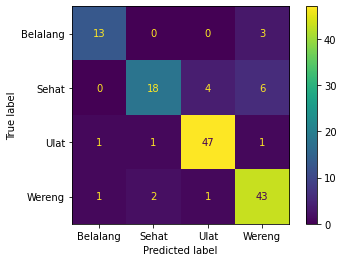

              precision    recall  f1-score   support

    Belalang       0.87      0.81      0.84        16
       Sehat       0.86      0.64      0.73        28
        Ulat       0.90      0.94      0.92        50
      Wereng       0.81      0.91      0.86        47

    accuracy                           0.86       141
   macro avg       0.86      0.83      0.84       141
weighted avg       0.86      0.86      0.85       141

[1.0266690910259881, 1.0586435804367065, 1.0540054761767386]
[1.0967375063896179, 0.9716869044303894, 1.0251536083221435]
FOLD 3
--------------------------------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can

Epoch: 0


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 1.423109769821167


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 1.2298862934112549


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 1.1770005226135254


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 1.1149765253067017


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 1.0886192321777344


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 1.03213632106781


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 1.0067448616027832


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 0.9837278723716736


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.9839999675750732


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 0.9387704133987427


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 0.9296007752418518


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 0.9651759266853333


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 0.9253330230712891


Epoch: 13


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 0.9281503558158875


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 0.9225447773933411


Epoch: 15


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Avg Valid Loss: 0.8799577355384827


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 0.8800330758094788


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 0.8672199249267578


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 0.8722936511039734


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.8464843034744263


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 0.8873255848884583


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 0.8699051141738892


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 0.8392683267593384


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 0.8537487387657166


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]

Avg Valid Loss: 0.8424741625785828




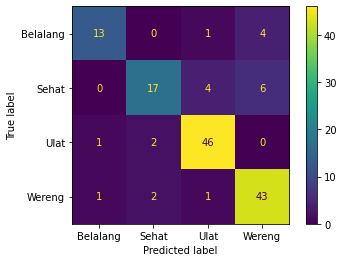

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can

              precision    recall  f1-score   support

    Belalang       0.87      0.72      0.79        18
       Sehat       0.81      0.63      0.71        27
        Ulat       0.88      0.94      0.91        49
      Wereng       0.81      0.91      0.86        47

    accuracy                           0.84       141
   macro avg       0.84      0.80      0.82       141
weighted avg       0.84      0.84      0.84       141

[1.0266690910259881, 1.0586435804367065, 1.0540054761767386, 1.0381516073942185]
[1.0967375063896179, 0.9716869044303894, 1.0251536083221435, 0.971539490222931]
FOLD 4
--------------------------------
Epoch: 0


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 1.6562526226043701


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 1.3446216583251953


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 1.2690865993499756


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 1.2460949420928955


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 1.1890860795974731


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 1.1286028623580933


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 1.114732027053833


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 1.1158527135849


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 1.02004873752594


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 1.0560860633850098


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 1.0084471702575684


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 0.9982340931892395


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 1.0223324298858643


Epoch: 13


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 1.0124337673187256


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 0.9438496232032776


Epoch: 15


100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Avg Valid Loss: 0.9374937415122986


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.9328117370605469


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 0.9823705554008484


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 0.9146676659584045


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 0.9595034718513489


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Avg Valid Loss: 0.9191180467605591


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 0.951887309551239


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 0.9387128949165344


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 0.8978523015975952


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

Avg Valid Loss: 0.9118745923042297




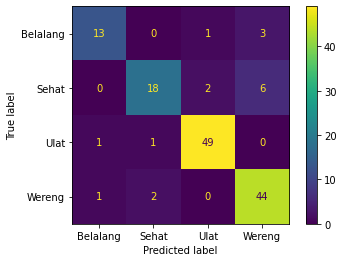

              precision    recall  f1-score   support

    Belalang       0.87      0.76      0.81        17
       Sehat       0.86      0.69      0.77        26
        Ulat       0.94      0.96      0.95        51
      Wereng       0.83      0.94      0.88        47

    accuracy                           0.88       141
   macro avg       0.87      0.84      0.85       141
weighted avg       0.88      0.88      0.88       141

[1.0266690910259881, 1.0586435804367065, 1.0540054761767386, 1.0381516073942185, 1.0471984168489774]
[1.0967375063896179, 0.9716869044303894, 1.0251536083221435, 0.971539490222931, 1.0588821482658386]


In [ ]:
from sklearn.model_selection import KFold

train_dataset = CCDataset(mode='train', augmentation=transform)
valid_dataset = CCDataset(mode='valid', augmentation=transform)
dataset = ConcatDataset([train_dataset, valid_dataset])
k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)
avg_train_loss = []
avg_val_loss = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print(f'FOLD {fold}')
  print('--------------------------------')
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  val_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = DataLoader(dataset=dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=4,
                                pin_memory=PIN_MEMORY,
                                collate_fn=collate_fn,
                                sampler=train_subsampler)


  valid_loader = DataLoader(dataset=dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                pin_memory=PIN_MEMORY,
                                collate_fn=collate_fn,
                                sampler=val_subsampler)
  model = get_model()
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
  
  model.train()
  train_error =[]
  val_error = []
  num_epochs = 25
  for epoch in range(num_epochs):
                  print(f"Epoch: {epoch}")
                  train = train_one_epoch(train_loader, model, optimizer, DEVICE)
                  vloss= validate(valid_loader, model, optimizer, DEVICE, epoch)
                  train_error.append(train)
                  val_error.append(vloss.tolist())

  import os
  from os import listdir

  hasil_pred = []
  
  # get the path/directory
  folder_dir = "/content/drive/MyDrive/Mask_RCNN/Dataset/test/"
  # x = os.listdir(folder_dir)
  # x

  for images in os.listdir(folder_dir):
  
      # check if the image ends with png
      if (images.endswith(".jpg")):
          # print(images)
        cap = cv2.VideoCapture(folder_dir+images)
        model.train(False)

        if (cap.isOpened()== False): 
            print("Error opening video stream or file")

        images = []   
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == True:
                result_frame, predict = predict_single_frame(frame)
                images.append(result_frame)
                hasil_pred.append (predict)
            else: 
                break

        cap.release()

  df_hasil_pred = pd.DataFrame(hasil_pred)
  df_hasil_pred [1] = pd.DataFrame(test_label)

  df_hasil_pred
  
  # df_hasil_pred
  import matplotlib.pyplot as plt
  import numpy
  from sklearn import metrics

  actual = df_hasil_pred[0]
  predicted = df_hasil_pred[1]

  confusion_matrix = metrics.confusion_matrix(actual, predicted)
  
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Belalang', 'Sehat', 'Ulat', 'Wereng'])

  cm_display.plot()
  plt.show()
  from sklearn.metrics import classification_report
  print(classification_report(actual, predicted, target_names=['Belalang', 'Sehat', 'Ulat', 'Wereng']))
  avg_train_loss.append(sum(train_error) / len(train_error))
  avg_val_loss.append(sum(val_error) / len(val_error))
  print(avg_train_loss)
  print(avg_val_loss)

 


In [ ]:
avg_train_loss

[1.0266690910259881,
 1.0586435804367065,
 1.0540054761767386,
 1.0381516073942185,
 1.0471984168489774]

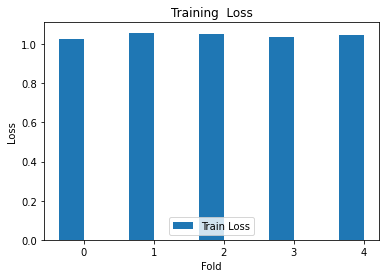

In [ ]:
index = np.arange(5)
x_label = [0,1,2,3,4]
bar_width = 0.35

fig, ax = plt.subplots()
train = ax.bar(index, avg_train_loss, bar_width,
                label="Train Loss")

# valid = ax.bar(index+bar_width, avg_val_loss,
                #  bar_width, label="Validation Loss")

ax.set_xlabel('Fold')
ax.set_ylabel('Loss')
ax.set_title('Training  Loss')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_label)

# ax.set_xticklabels(["ASB", "Violence", "Theft", "Public Order", "Drugs"])
ax.legend()

plt.show()

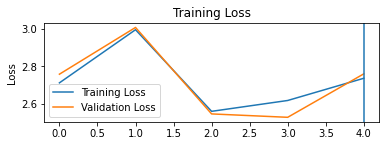

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.legend()
plt.title('Training Loss')
plt.axvline(4,  label="Epoch")
# plt.ylabel('merror')
plt.ylabel('Loss')

plt.show()

In [ ]:
from torchvision.utils import draw_bounding_boxes

In [ ]:
import cv2

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Pest', 'Belalang', 'Sehat', 'Ulat', 'Wereng']

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(result_frame)

In [ ]:
!pip install paho-mqtt
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for paho-mqtt: filename=paho_mqtt-1.6.1-py3-none-any.whl size=62132 sha256=bf8bd21e75c68779898b585bc5545bbb053e8af69b1c9f55fed6bc4e3a845088
  Stored in directory: /root/.cache/pip/wheels/6a/48/01/c895c027e9b9367ec5470fbf371ee56e795a49ac6a19aa4c9f
Successfully built paho-mqtt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import time

from paho.mqtt import client as mqtt_client

broker = 'broker.emqx.io'
port = 1883
topic1 = "detect/Pest"
# topic0 = "detect/healthy"
# generate client ID with pub prefix randomly
client_id = f'python-mqtt-{random.randint(0, 1000)}'
username = 'emqx'
password = 'public'

def connect_mqtt():
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print("Failed to connect, return code %d\n", rc)

    client = mqtt_client.Client(client_id)
    client.username_pw_set(username, password)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client


def publish(client):
    
    msg_count = 0
    msg = ''
    while True:
        time.sleep(1)
        # pred = predict()
        # print (pred)
        deteksi = []
        for i in predicted:
            if (i == 'Pest')  :
                j = 'Pest'
                deteksi.append(j)
            else:
                j = 'healthy'
                deteksi.append(j)
        # print (deteksi)
    
        for x in deteksi:
            if (x == 'Pest'):
                msg = "Pest"
                result = client.publish(topic1, msg)
                status = result[0]
                if status == 0:
                    print(f"Send `{msg}` to topic `{topic1}`")
                else:
                    print(f"Failed to send message to topic {topic1}")


def run():
    client = connect_mqtt()
    client.loop_start()
    publish(client)


In [ ]:
run()

Streaming output truncated to the last 5000 lines.
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send

KeyboardInterrupt: ignored